Saving cure_the_princess_test.csv to cure_the_princess_test (7).csv
Saving cure_the_princess_train.csv to cure_the_princess_train (7).csv
Saving cure_the_princess_validation.csv to cure_the_princess_validation (7).csv
Epoch 1/50, Train Loss: 1.0838, Val Loss: 0.4528, Val Acc: 0.4968, Val F1: 0.6638, Val Precision: 0.4968, Val Recall: 1.0000
Epoch 2/50, Train Loss: 0.9233, Val Loss: 0.3049, Val Acc: 0.4968, Val F1: 0.6638, Val Precision: 0.4968, Val Recall: 1.0000
Epoch 3/50, Train Loss: 0.8524, Val Loss: 0.2526, Val Acc: 0.4968, Val F1: 0.6638, Val Precision: 0.4968, Val Recall: 1.0000
Epoch 4/50, Train Loss: 0.8386, Val Loss: 0.2247, Val Acc: 0.4968, Val F1: 0.6638, Val Precision: 0.4968, Val Recall: 1.0000
Epoch 5/50, Train Loss: 0.7808, Val Loss: 0.2460, Val Acc: 0.4968, Val F1: 0.6638, Val Precision: 0.4968, Val Recall: 1.0000
Epoch 6/50, Train Loss: 0.7745, Val Loss: 0.1982, Val Acc: 0.4968, Val F1: 0.6638, Val Precision: 0.4968, Val Recall: 1.0000
Epoch 7/50, Train Loss: 0.7710, 

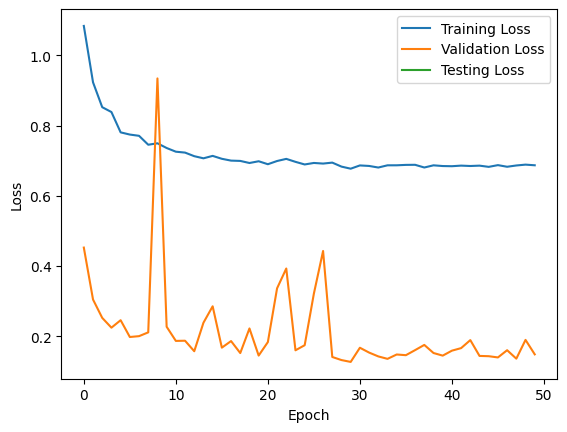

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# Set seed
torch.manual_seed(170401085)

# create empty lists to store the training, validation, and test losses
train_losses = []
val_losses = []
test_losses = []
# Upload the train and validation datasets
uploaded = files.upload()

# Read the train and validation datasets into Pandas DataFrames
train_df = pd.read_csv('cure_the_princess_train.csv')
val_df = pd.read_csv('cure_the_princess_validation.csv')
test_df=pd.read_csv('cure_the_princess_test.csv')

# Extract the features and labels from the train and validation DataFrames
train_data = train_df.drop(['Cured'], axis=1).to_numpy()
train_labels = train_df['Cured'].to_numpy().reshape(-1, 1).astype(float)
val_data = val_df.drop(['Cured'], axis=1).to_numpy()
val_labels = val_df['Cured'].to_numpy().reshape(-1, 1).astype(float)
test_data = test_df.drop(['Cured'], axis=1).to_numpy()
test_labels = test_df['Cured'].to_numpy().reshape(-1, 1).astype(float)

# Convert the NumPy arrays to PyTorch Tensors
train_data = torch.from_numpy(train_data).float()
train_labels = torch.from_numpy(train_labels).float()
val_data = torch.from_numpy(val_data).float()
val_labels = torch.from_numpy(val_labels).float()
test_data = torch.from_numpy(test_data).float()
test_labels = torch.from_numpy(test_labels).float()

# Create the training and validation datasets and test data
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
val_dataset = torch.utils.data.TensorDataset(val_data, val_labels)
test_dataset = torch.utils.data.TensorDataset(test_data, test_labels)

# Create the training and validation dataloaders and test data 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)


# Define the model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(13, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

model = MLP()

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train and validation loops
train_losses = []
val_losses = []
val_accuracies= []
val_f1s= []
val_precisions= []
val_recalls= []
num_epochs = 50

# define your regularization hyperparameters
l2_lambda = 0.01

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    true_positives, false_positives, true_negatives, false_negatives = 0, 0, 0, 0

    # Train
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # calculate L2 regularization term
        l2_regularization = torch.tensor(0.0, requires_grad=False)
        for param in model.parameters():
            l2_regularization += torch.sum(torch.square(param.detach()))
        loss += l2_lambda * l2_regularization
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # calculate validation accuracy, F1 score, precision, and recall
            predicted_labels = torch.round(torch.sigmoid(outputs))
            true_positives += torch.sum(predicted_labels * labels).item()
            false_positives += torch.sum(predicted_labels * (1 - labels)).item()
            true_negatives += torch.sum((1 - predicted_labels) * (1 - labels)).item()
            false_negatives += torch.sum((1 - predicted_labels) * labels).item()
    
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    
    val_accuracy = (true_positives + true_negatives) / len(val_loader.dataset)
    val_f1 = 2 * true_positives / (2 * true_positives + false_positives + false_negatives)
    val_precision = true_positives / (true_positives + false_positives)
    val_recall = true_positives / (true_positives + false_negatives)
    
    val_accuracies.append(val_accuracy)
    val_f1s.append(val_f1)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")


# plot the training, validation, and test losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
 

# New Section